<div style="text-align: center; background-color: #0077b6; padding: 20px; border-radius: 10px;">
  <h1 style="color: white; font-weight: bold;">OCRFlux-3B: Testing Document Parsing Across Different Examples</h1>
</div>


In this notebook, we explore and evaluate **[OCRFlux-3B](https://huggingface.co/ChatDOC/OCRFlux-3B)**, a powerful open-source model developed for document parsing and OCR (Optical Character Recognition). Our goal is to test its performance across a variety of page images sourced from different types of documents. The core implementation and setup are based on the excellent tutorial provided by [Venelin Valkov](https://www.youtube.com/@venelin_valkov/videos). This notebook is executed on **Lightning AI** using an **NVIDIA L40S GPU**, allowing us to leverage accelerated hardware for efficient inference.

# **1. Import Libraries**

In [2]:
from PIL import Image
from transformers import AutoTokenizer, AutoProcessor, AutoModelForImageTextToText
from rich.console import Console
from bs4 import BeautifulSoup
from IPython.display import display, HTML
import json
from rich.pretty import pprint
from rich.table import Table
from rich.markdown import Markdown
import base64
from markdown import markdown

# **2. Load OCRFlux-3B**

In [4]:
model_path = "ChatDOC/OCRFlux-3B"

model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto",
    #attn_implementation="flash_attention_2",
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

# **3. Define the Prompt**

In [14]:
EXTRACT_PROMPT = (
    "Below is the image of one page of a document. "
    "Just return the plain text representation of this document as if you were reading it naturally.\n"
    "ALL tables should be presented in HTML format.\n"
    'If there are images or figures in the page, present them in table format.\n'
    "Present all titles and headings as H1 headings.\n"
    "Do not hallucinate.\n"
)

# **4. Inference**

In [16]:
def ocr_page(image_path, model, processor, max_new_tokens=4096):
    image = Image.open(image_path)
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": f"file://{image_path}"},
                {"type": "text", "text": EXTRACT_PROMPT},
            ],
        },
    ]
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to(model.device)

    output_ids = model.generate(
        **inputs, temperature=0.0, max_new_tokens=max_new_tokens, do_sample=False
    )
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text[0]

In [17]:
def display_vertical_split(image_path: str, html_content: str):
    try:
        with open(image_path, "rb") as f:
            image_data = f.read()

        ext = image_path.split(".")[-1].lower()
        mime_map = {
            "jpg": "jpeg",
            "jpeg": "jpeg",
            "png": "png",
            "gif": "gif",
            "svg": "svg+xml",
        }
        mime_type = f"image/{mime_map.get(ext, 'png')}"
        b64_image = base64.b64encode(image_data).decode("utf-8")
        image_uri = f"data:{mime_type};base64,{b64_image}"

    except FileNotFoundError:
        print(f"Error: Image file not found at '{image_path}'")
        return
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")
        return

    # Step 3: Convert Markdown to HTML, enabling the 'extra' extension for tables
    # Do NOT wrap the source markdown text, as it will break table syntax.
    html_content = markdown(html_content.replace("\$", "$"), extensions=["extra"])

    # Step 4: Construct the HTML and CSS for the vertical split view
    # We add a <style> block to properly format the markdown output, especially tables.
    html_template = f"""
    <style>
        .container {{
            display: flex;
            align-items: flex-start;
            width: 100%;
            border: 1px solid #e0e0e0;
            border-radius: 8px;
            overflow: hidden;
            font-family: sans-serif;
        }}
        .pane {{
            flex: 1;
            padding: 15px;
            min-width: 0; /* Important for flexbox wrapping */
        }}
        .pane img {{
            width: 100%;
            height: auto;
            object-fit: contain;
            border-radius: 4px;
        }}
        .divider {{
            width: 1px;
            background-color: #e0e0e0;
            align-self: stretch;
        }}
        /* Markdown-specific styles */
        .markdown-body {{
            font-size: 14px;
            line-height: 1.6;
        }}
        .markdown-body h1, .markdown-body h2, .markdown-body h3 {{
            border-bottom: 1px solid #eee;
            padding-bottom: .3em;
            margin-top: 24px;
            margin-bottom: 16px;
        }}
        .markdown-body table {{
            border-collapse: collapse;
            width: 100%;
            margin-top: 1em;
            margin-bottom: 1em;
        }}
        .markdown-body th, .markdown-body td {{
            border: 1px solid #ccc;
            padding: 8px 12px;
            text-align: left;
        }}
        .markdown-body th {{
            font-weight: bold;
        }}
        .markdown-body code {{
            background-color: rgba(27,31,35,.05);
            padding: .2em .4em;
            margin: 0;
            font-size: 85%;
            border-radius: 3px;
        }}
    </style>

    <div class="container">
      <!-- Left Pane: Image -->
      <div class="pane">
        <img src="{image_uri}">
      </div>

      <!-- Vertical Divider -->
      <div class="divider"></div>

      <!-- Right Pane: Markdown Text -->
      <div class="pane markdown-body">
        {html_content}
      </div>
    </div>
    """
    display(HTML(html_template))

## **Example n°1**

In [18]:
%%time

image_path = "cga_images/RAP_CGA_FR_ANG_2022-images-79 (1) (1).jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 1min 1s, sys: 31.7 ms, total: 1min 1s
Wall time: 1min 1s



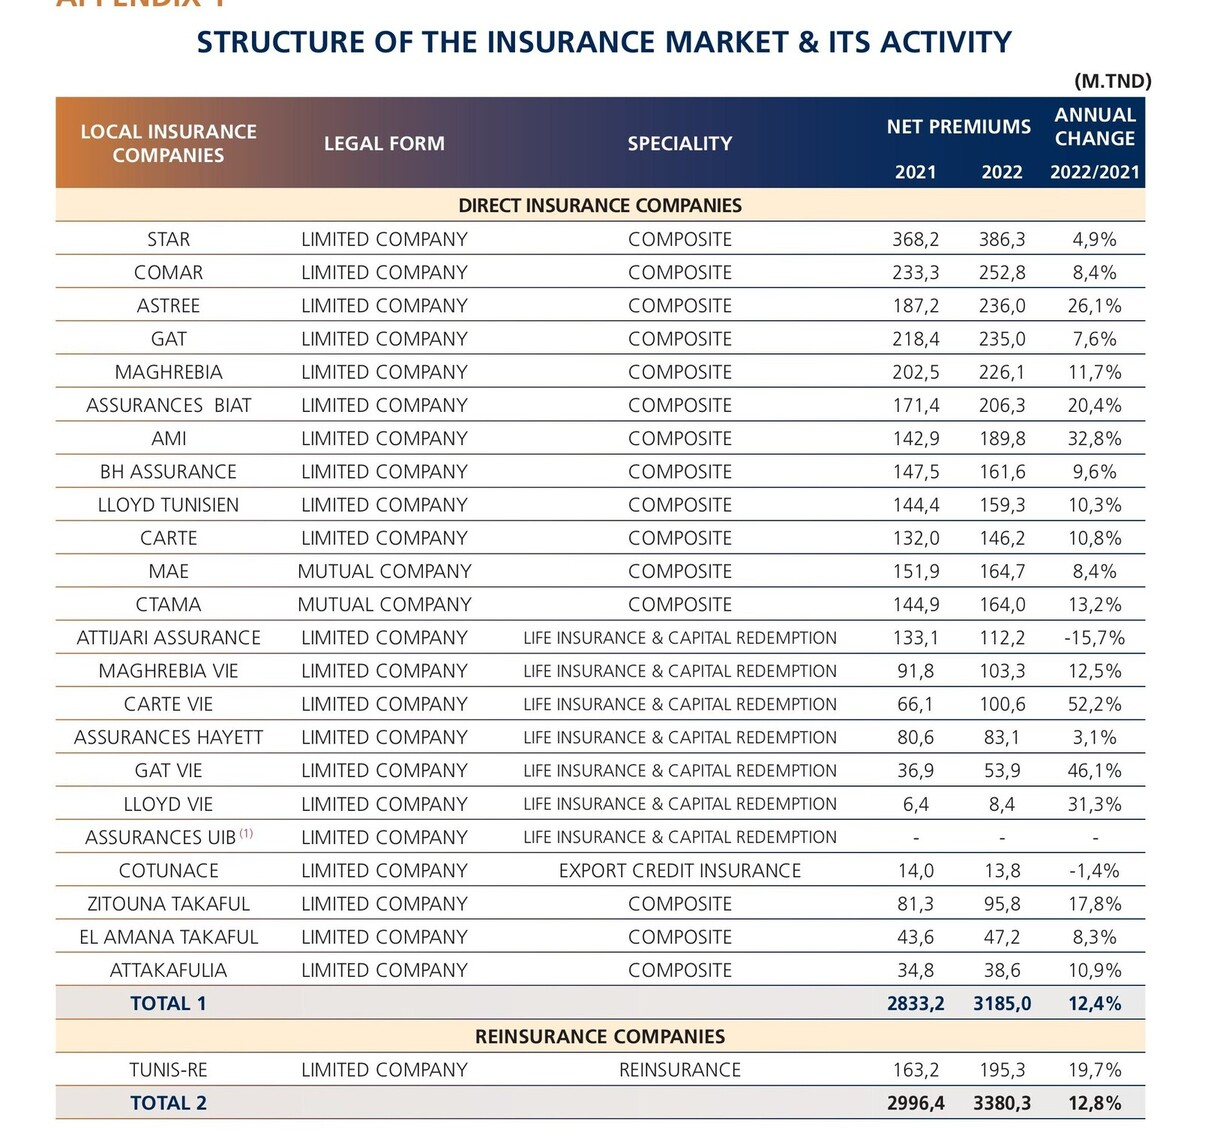

In [20]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°2**

In [21]:
%%time

image_path = "Different_Tables_Images_Testing/other_table.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 2min 52s, sys: 341 ms, total: 2min 53s
Wall time: 2min 53s



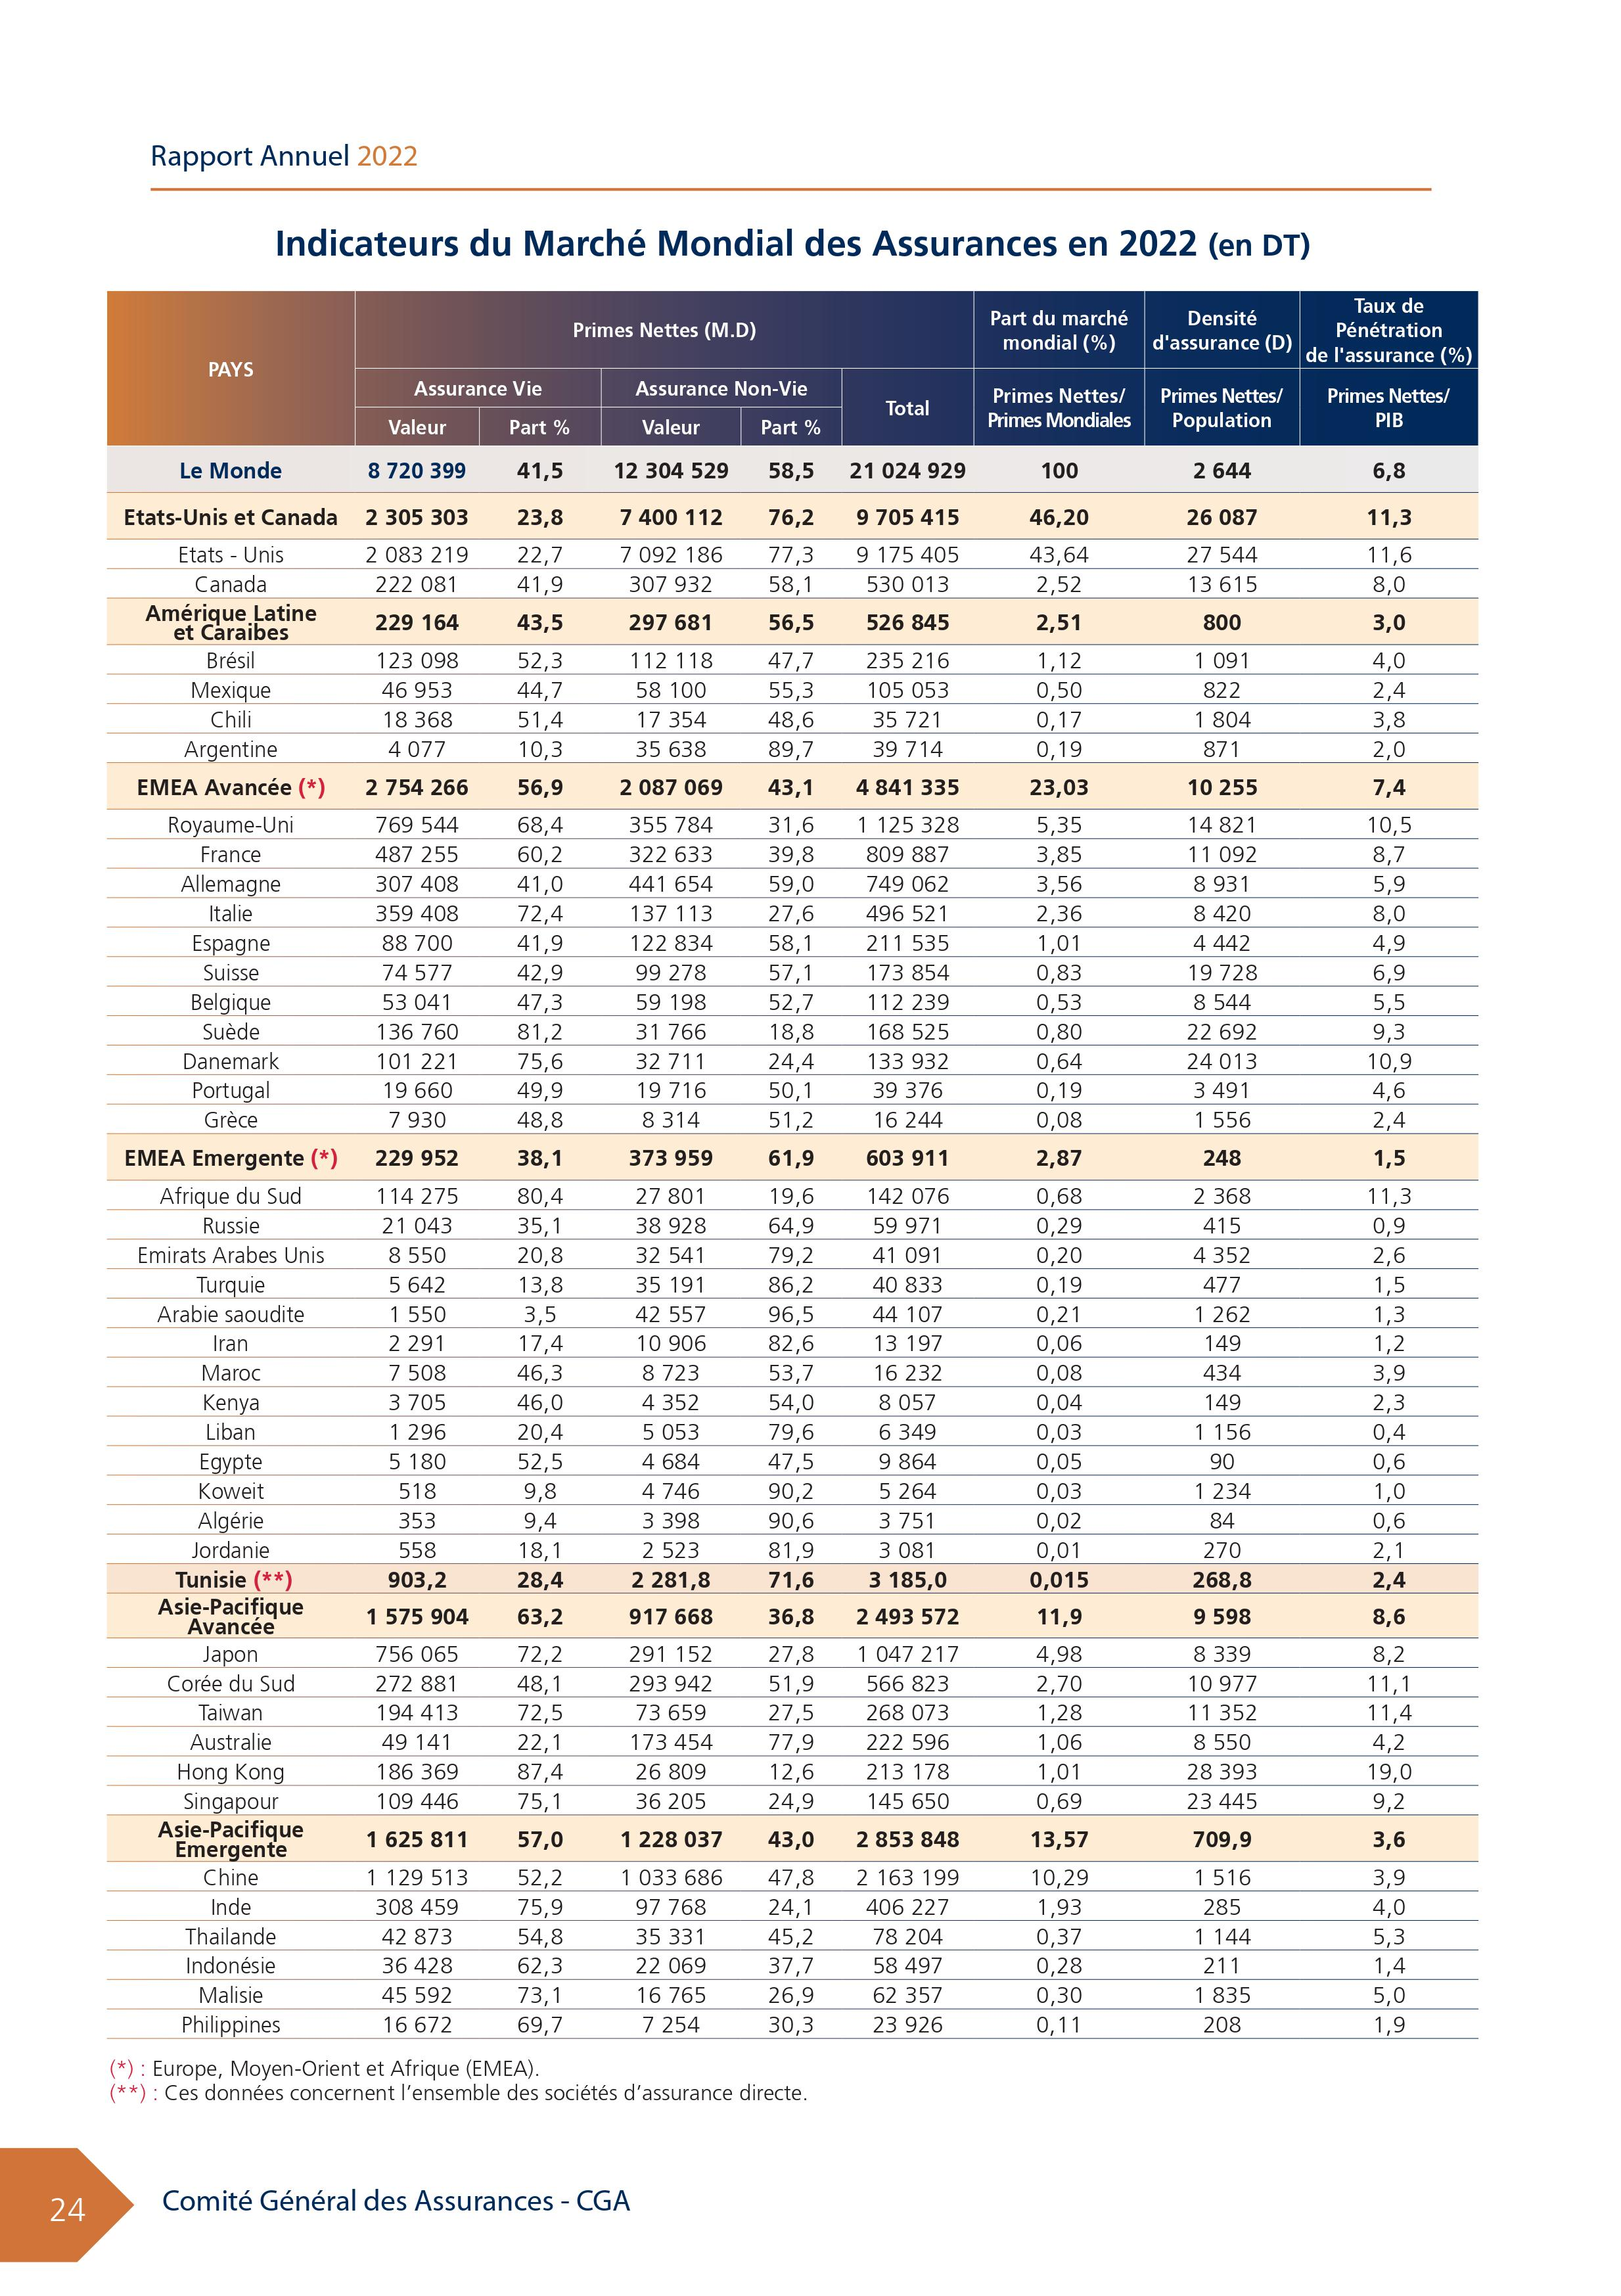

In [22]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°3**

In [23]:
%%time

image_path = "cga_images/RAP_CGA_FR_ANG_2022-images-15.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 28.6 s, sys: 290 ms, total: 28.9 s
Wall time: 28.8 s



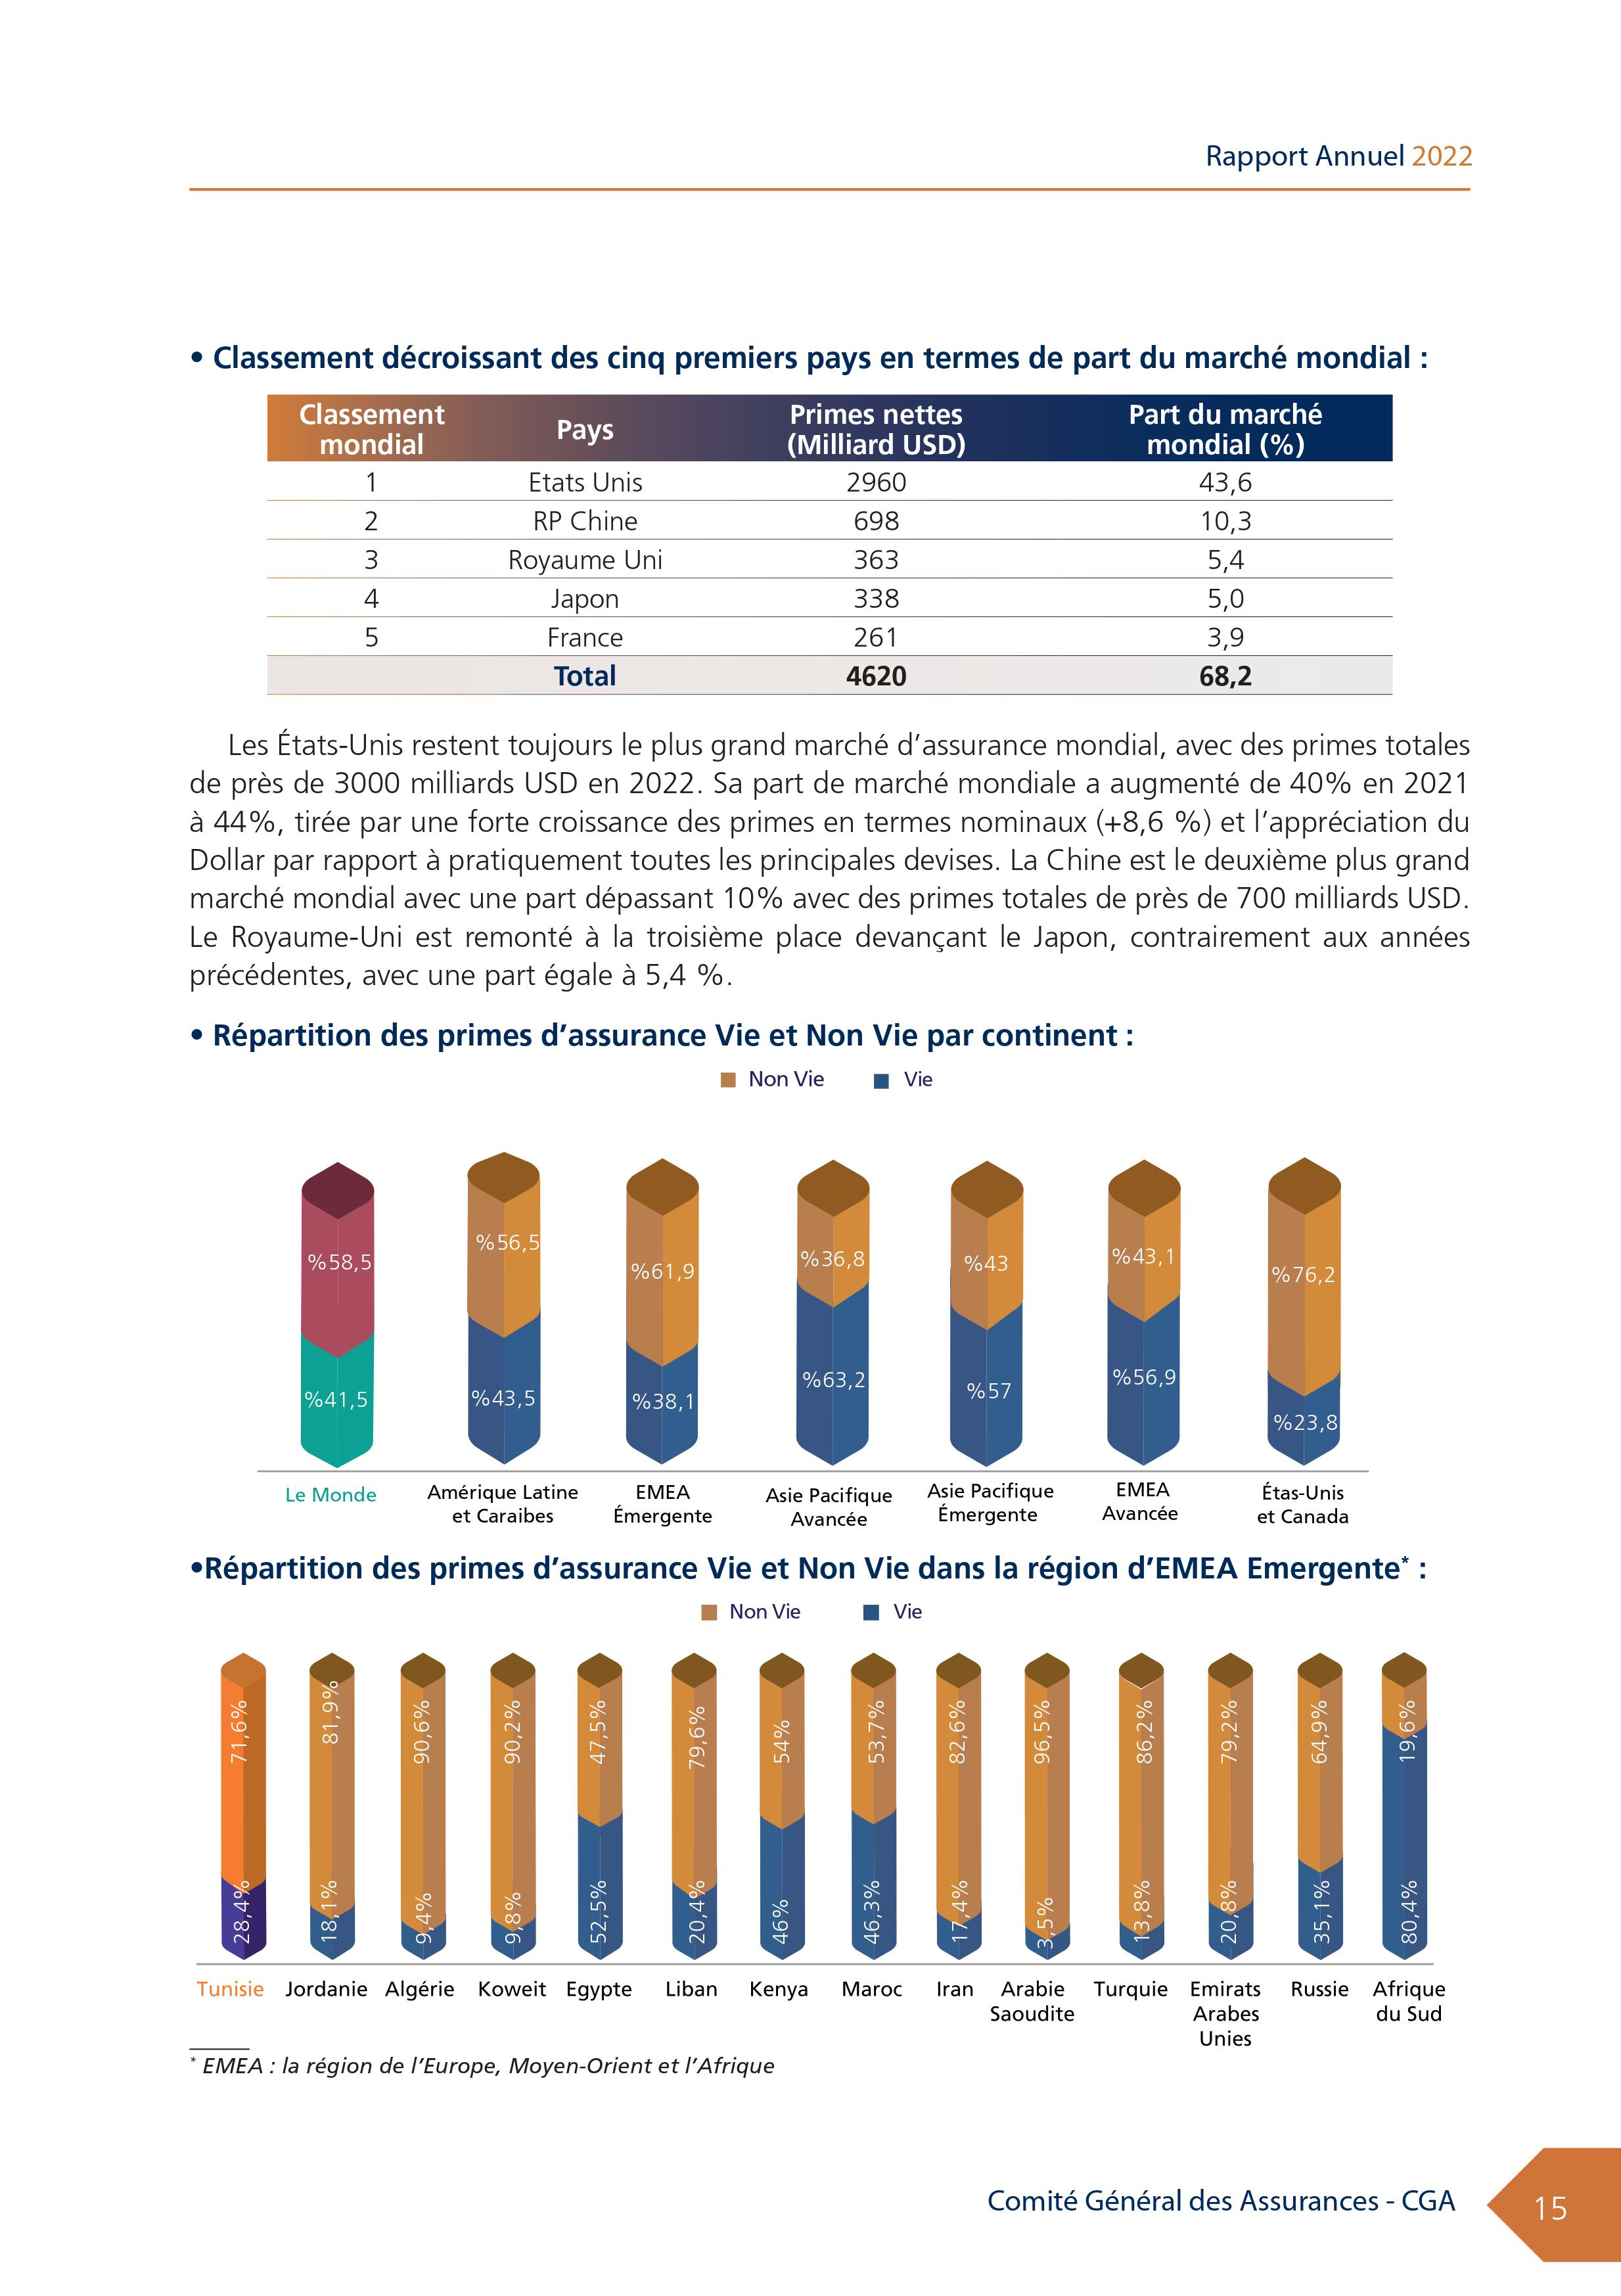

In [24]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°4**

In [25]:
%%time

image_path = "Different_Tables_Images_Testing/NVIDIA_Report_Removed_Pages-1-16-14_page-0001.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 44.1 s, sys: 33.2 ms, total: 44.2 s
Wall time: 44.2 s



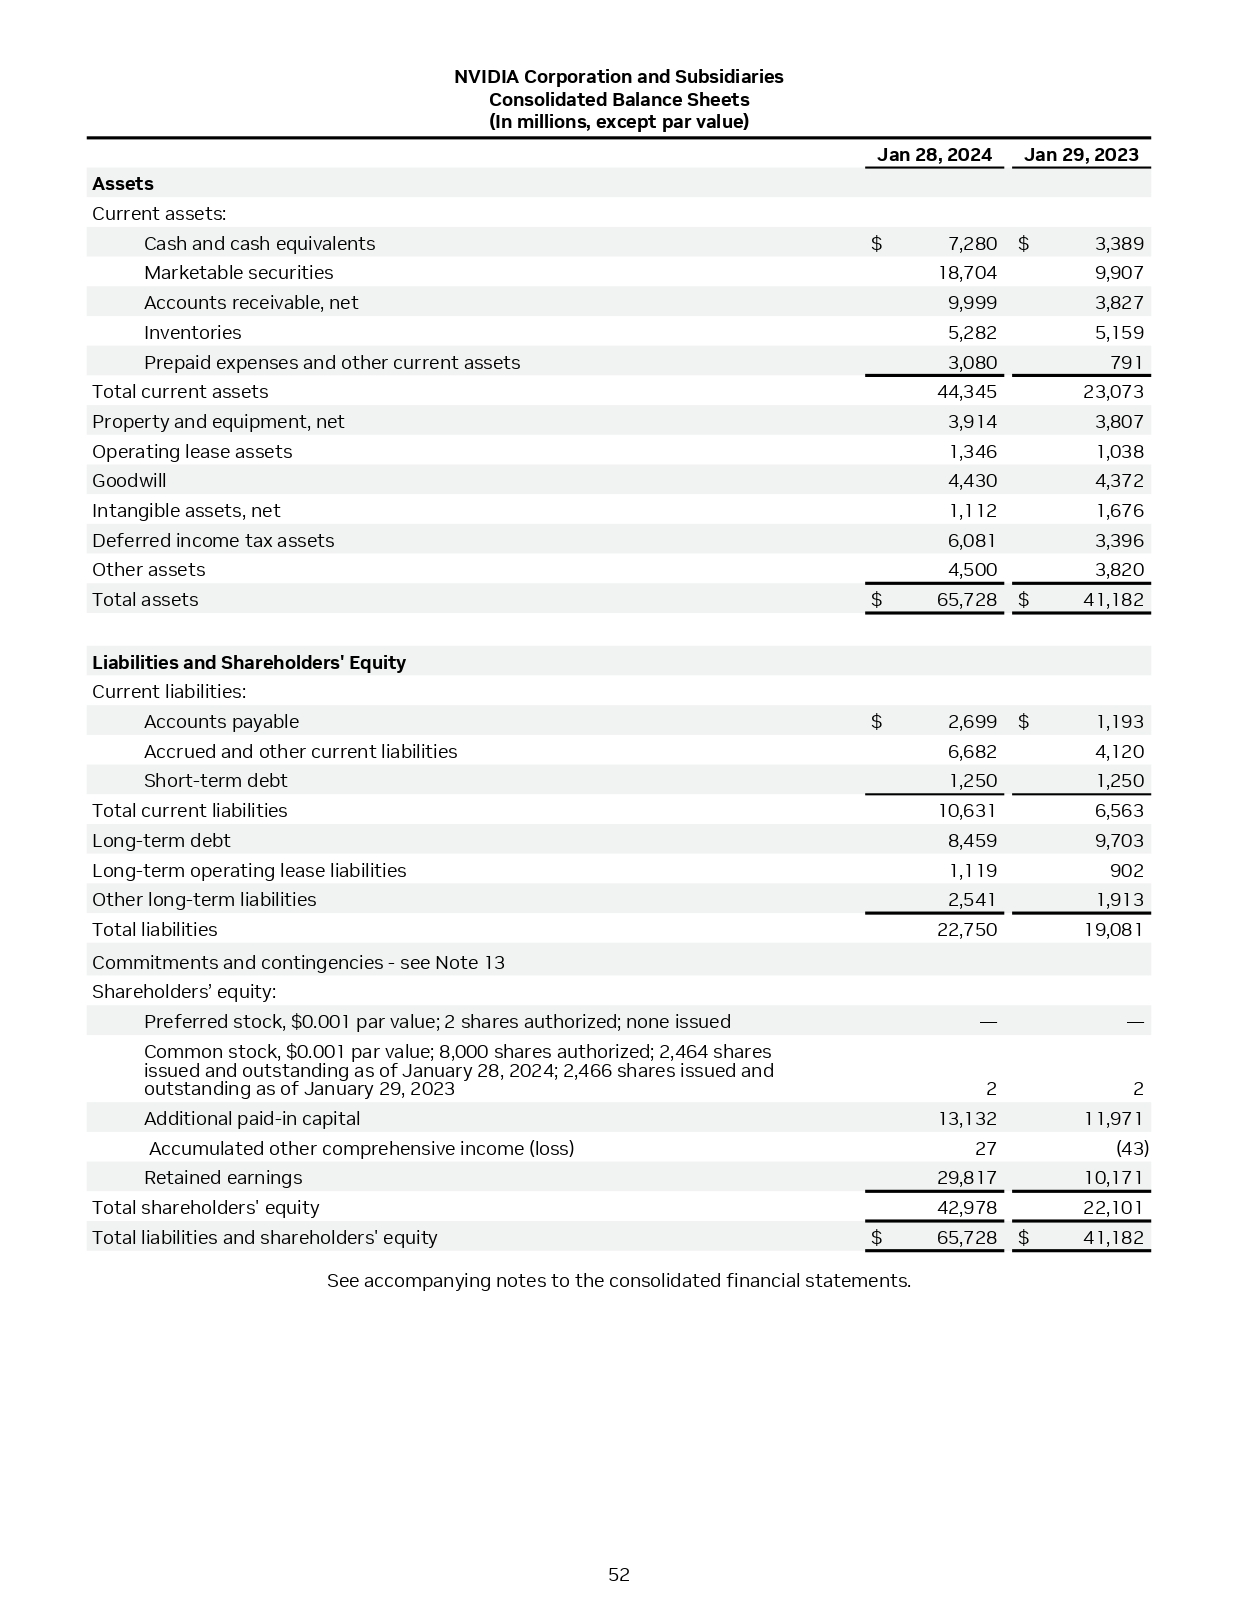

In [26]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°5**

In [27]:
%%time

image_path = "pdf_files_pages/Blackstone4Q24EarningsPressRelease_page-0020.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 1min 37s, sys: 33.6 ms, total: 1min 37s
Wall time: 1min 37s



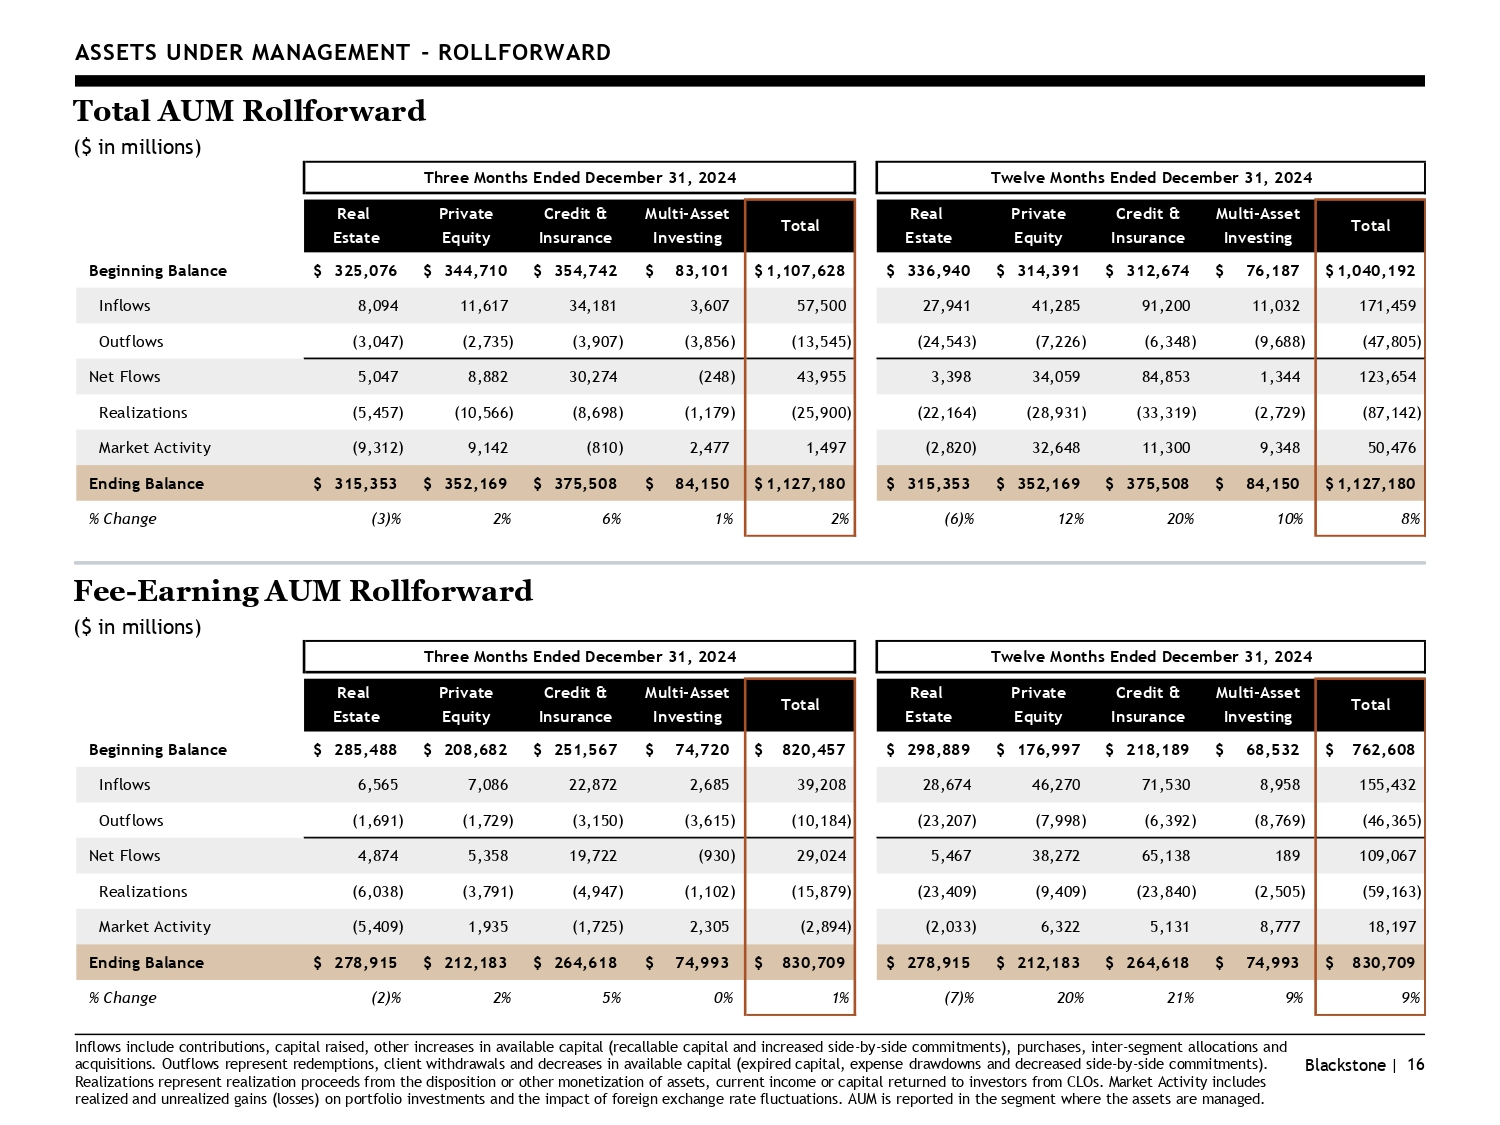

In [28]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°6**

In [29]:
%%time

image_path = "pdf_files_pages/RHG_annual_report_2022_page-0047.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 1min 19s, sys: 35.7 ms, total: 1min 19s
Wall time: 1min 19s



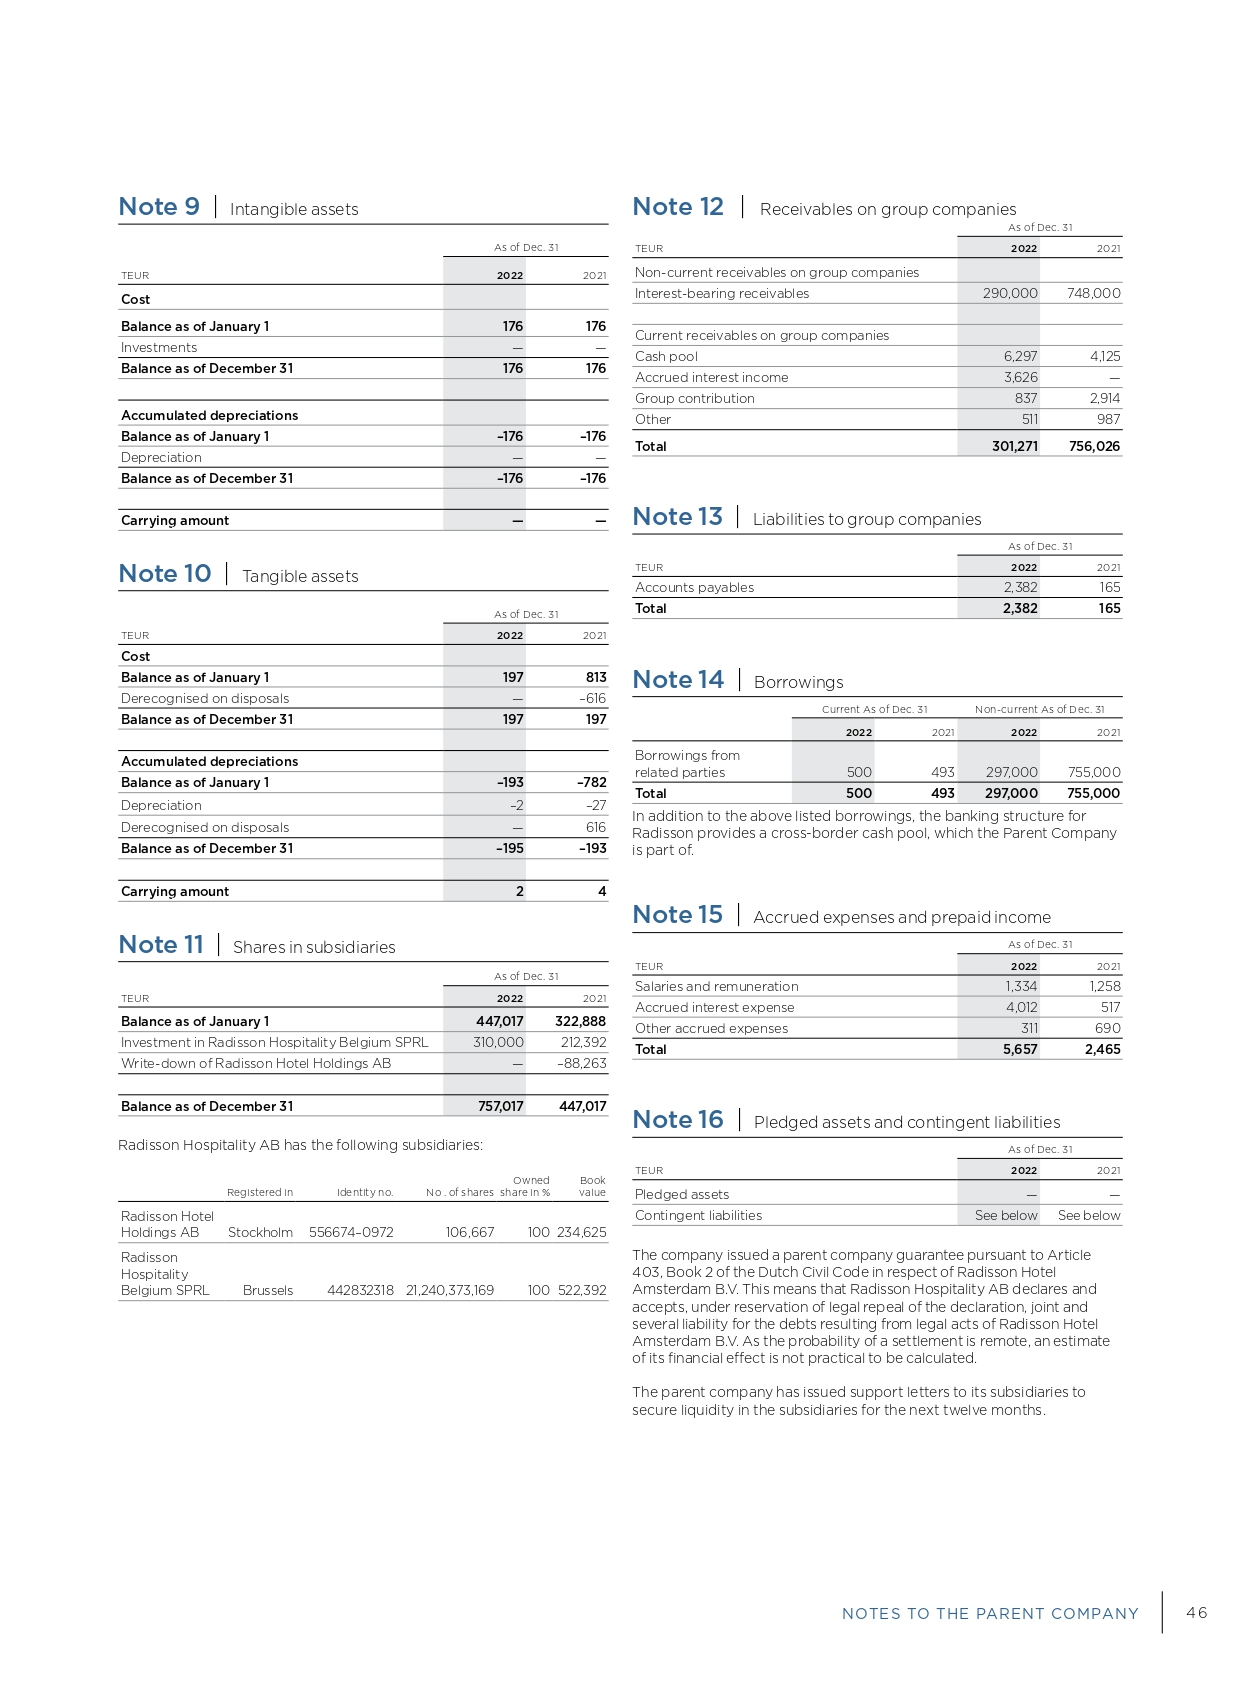

In [30]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°7**

In [31]:
%%time

image_path = "pdf_files_pages/CLAS-FY2023-AR_page-0076.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 52.1 s, sys: 66.4 ms, total: 52.1 s
Wall time: 52.1 s



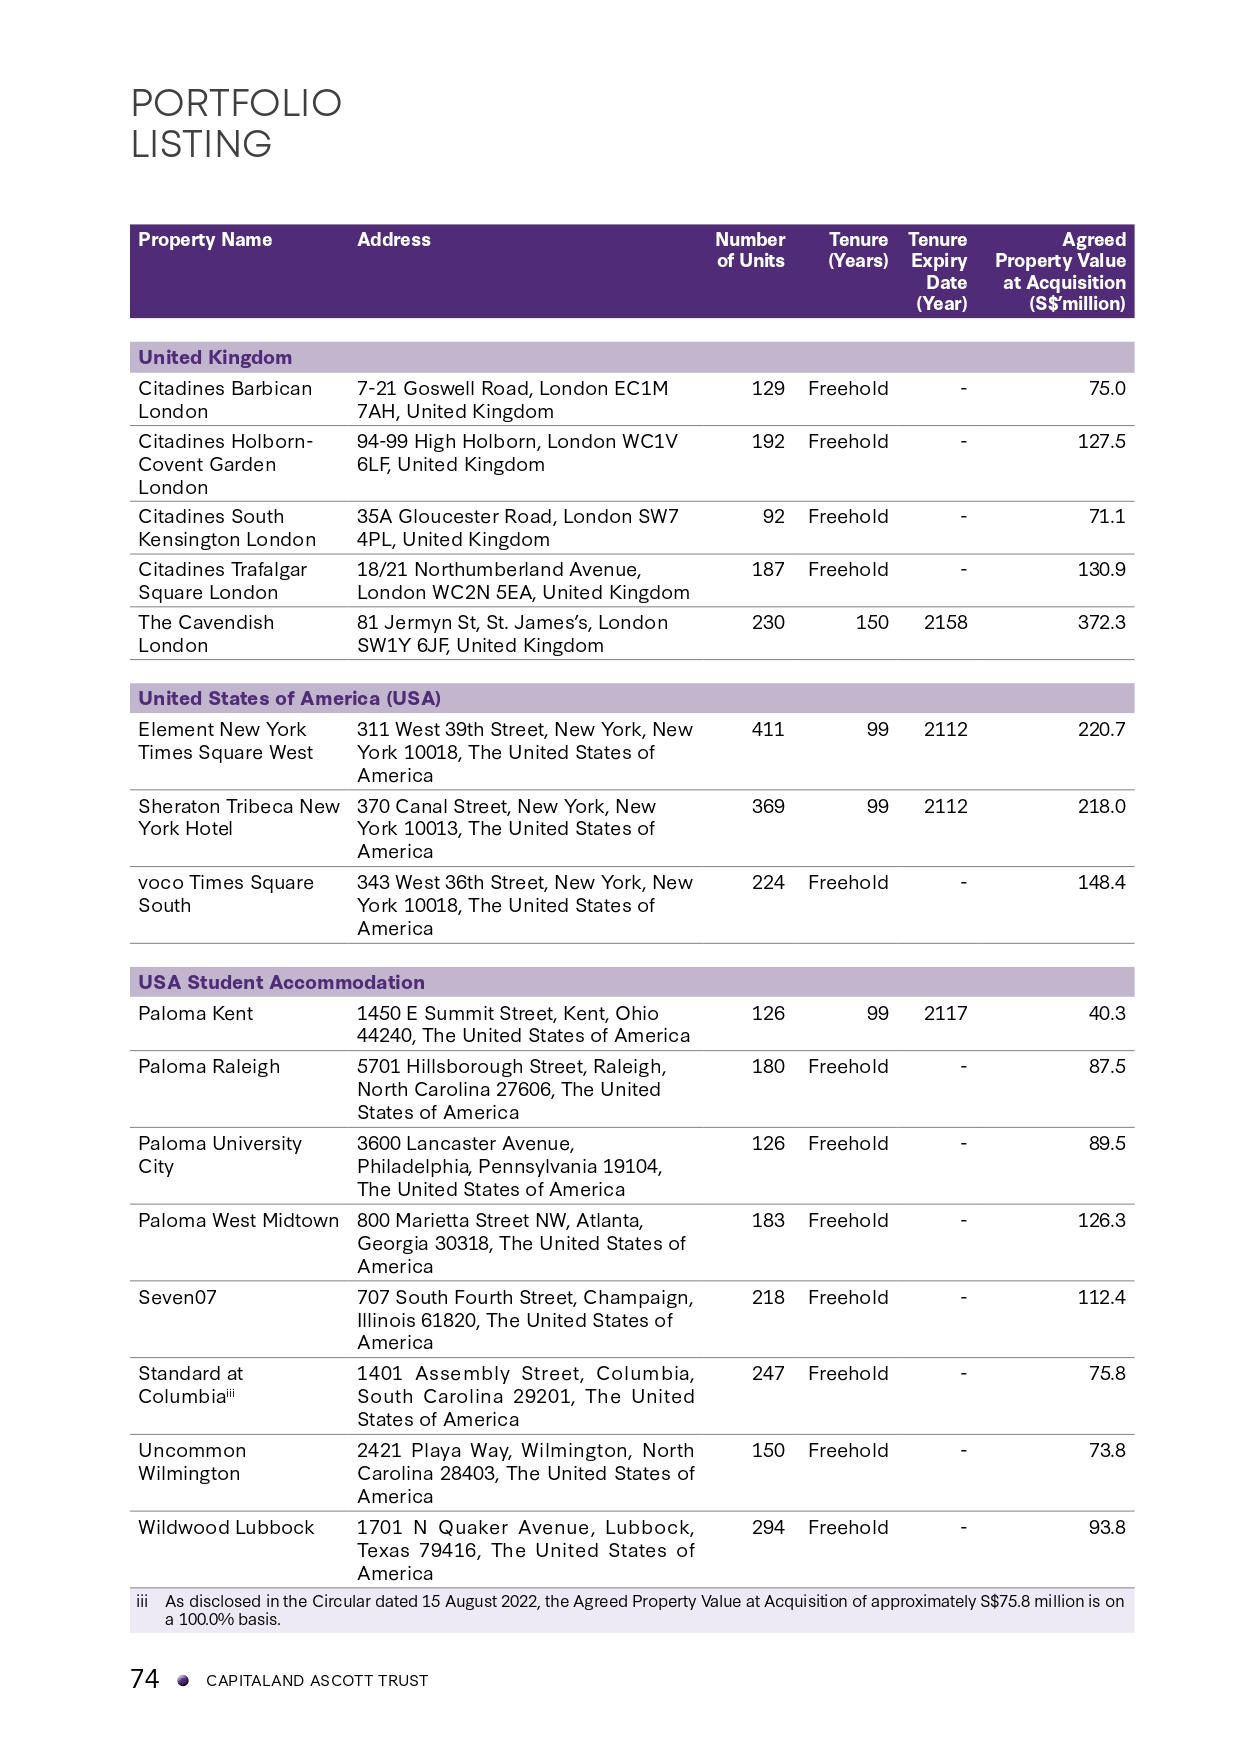

In [32]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°8**

In [33]:
%%time

image_path = "Different_Tables_Images_Testing/table_3.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 1min 22s, sys: 190 ms, total: 1min 22s
Wall time: 1min 22s



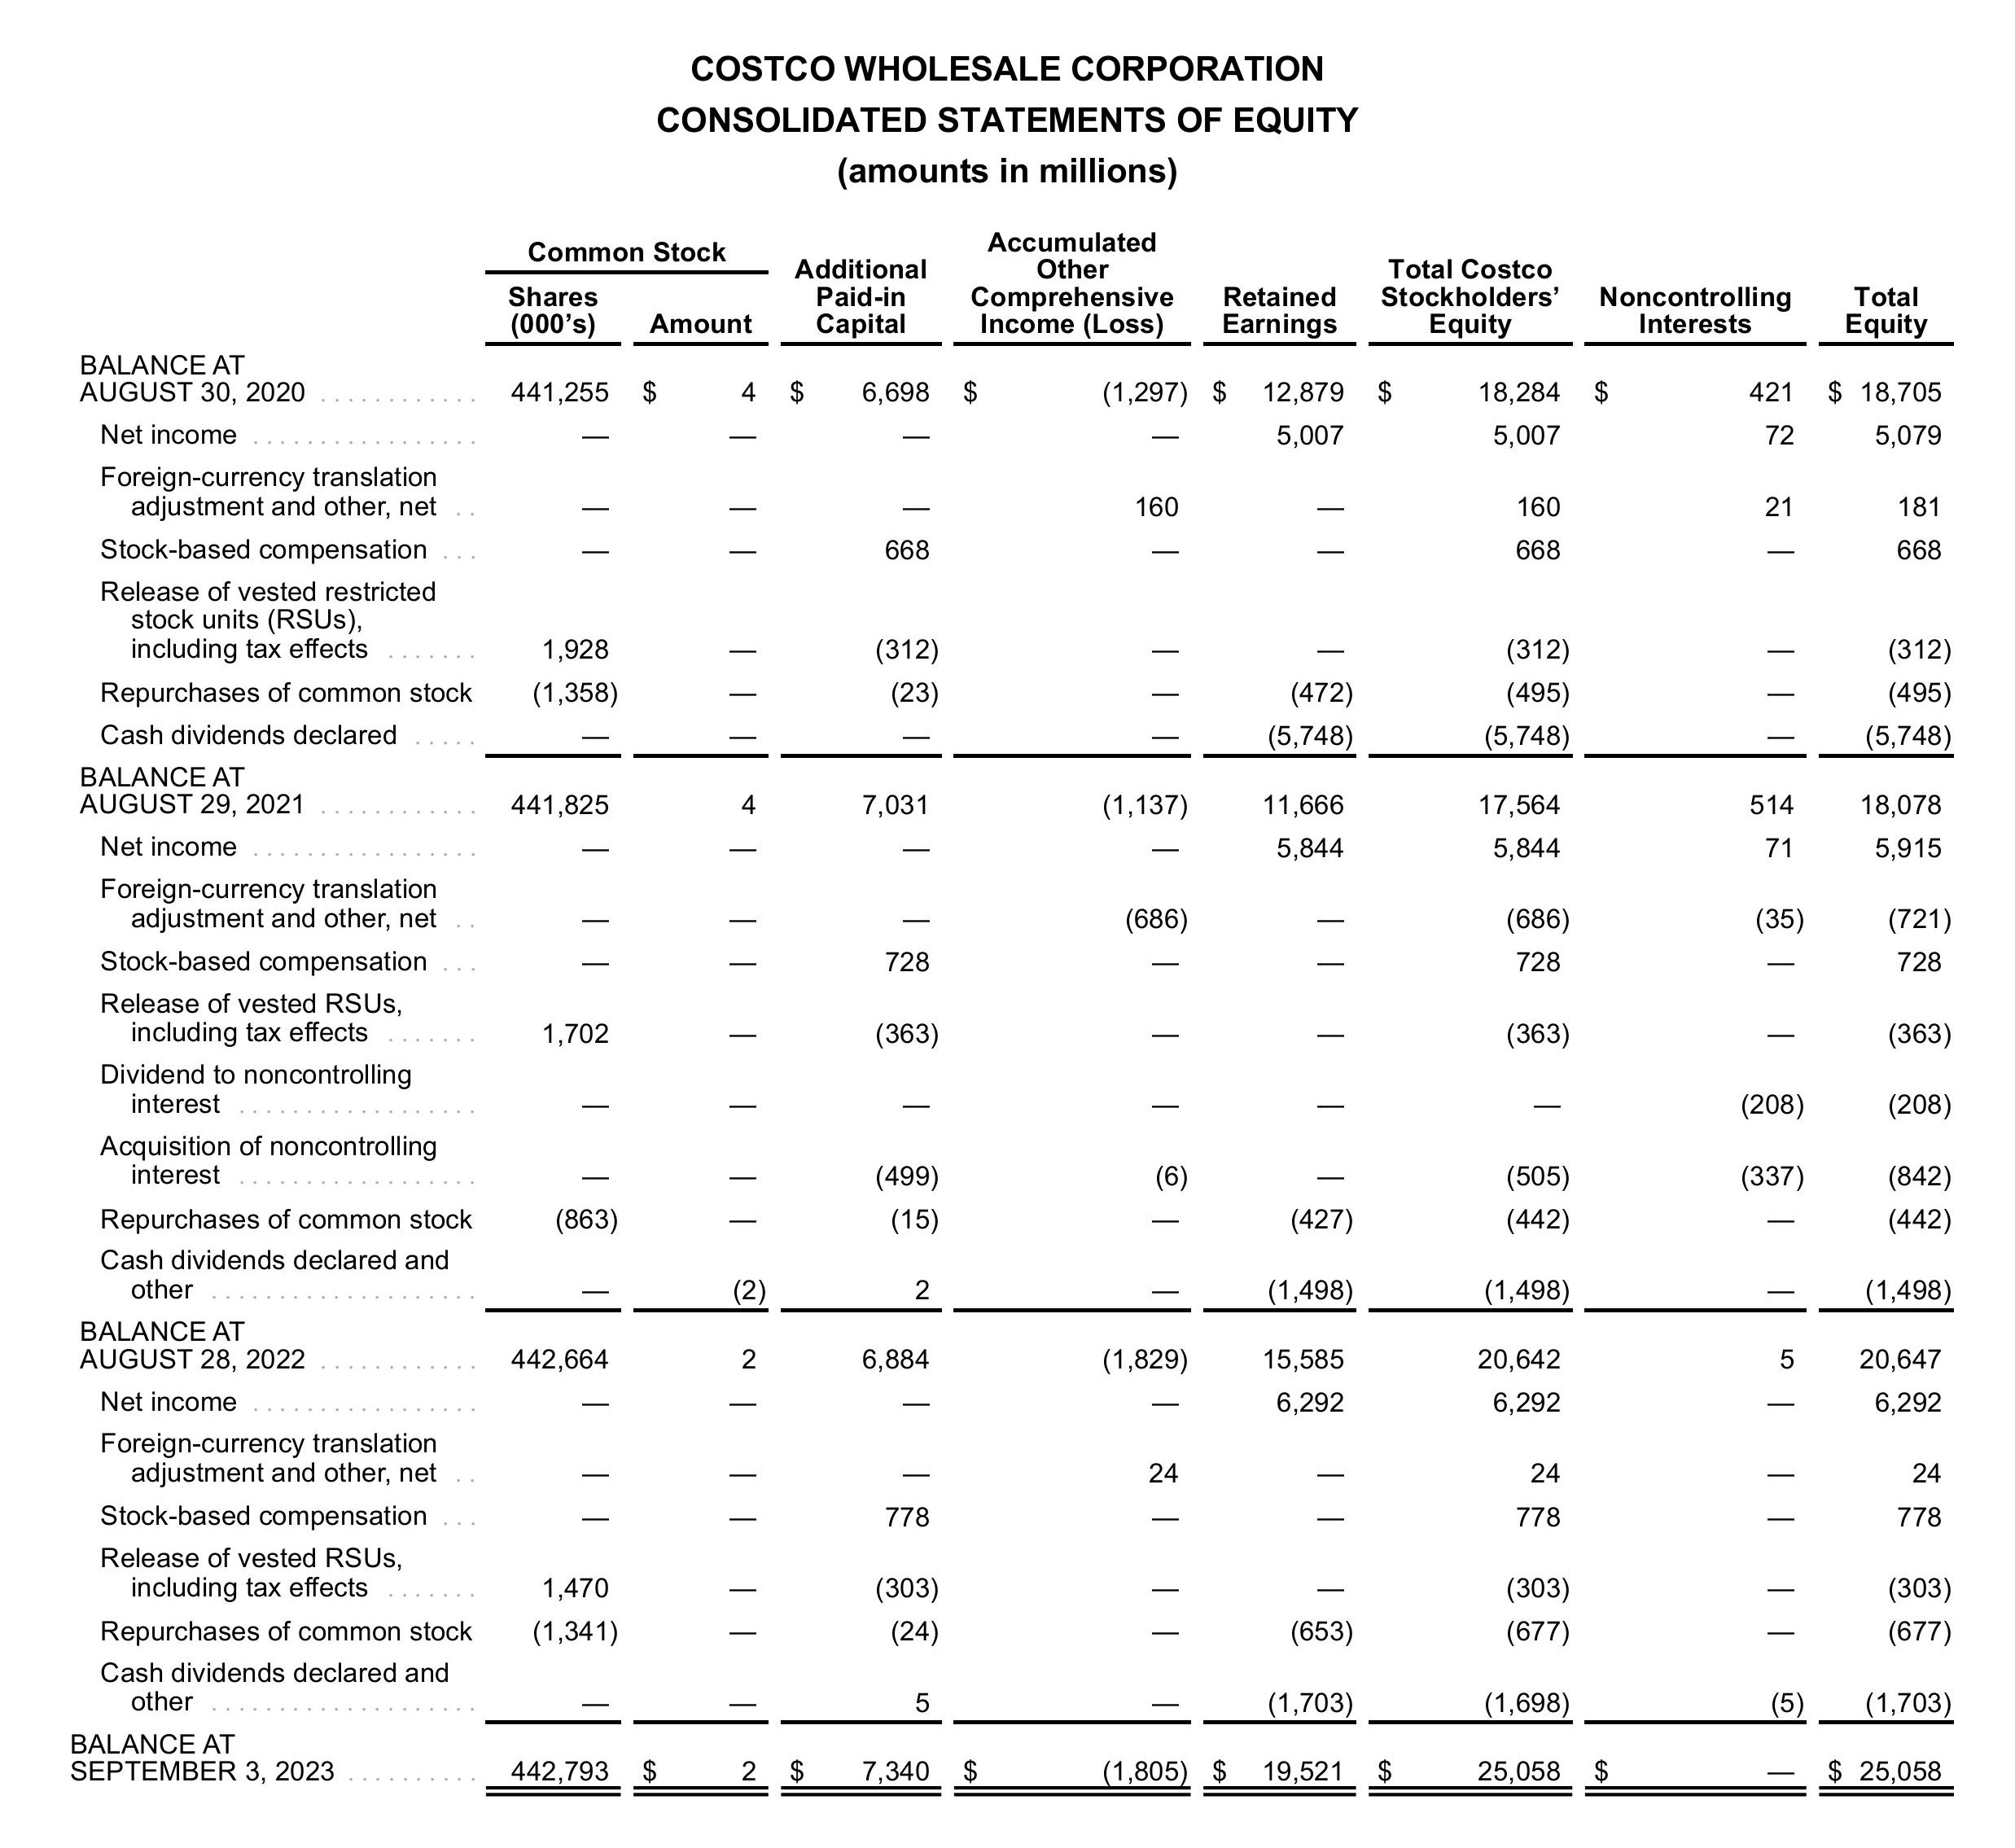

In [34]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°9**

In [35]:
%%time

image_path = "pdf_files_pages/CLAS-FY2023-AR_page-0066.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 59.2 s, sys: 75.4 ms, total: 59.3 s
Wall time: 59.3 s



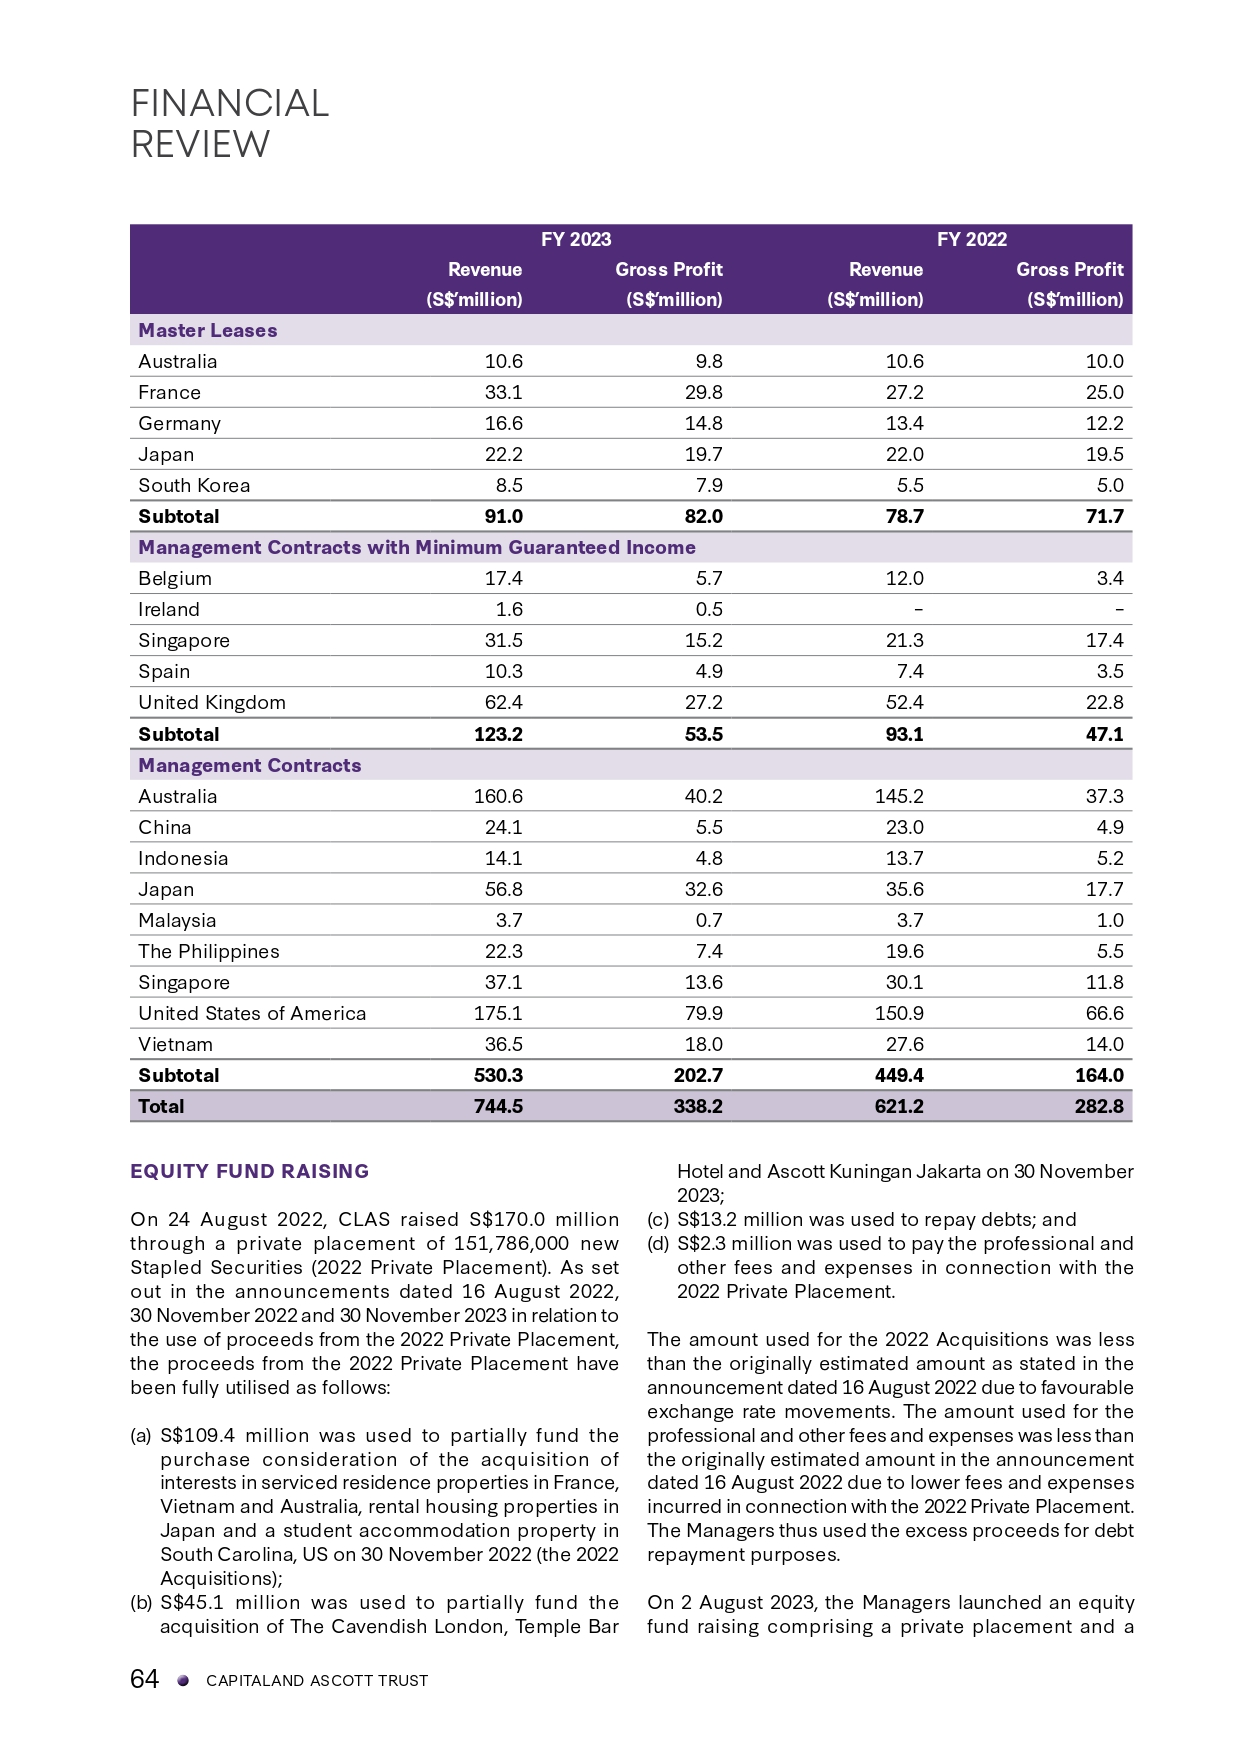

In [36]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)

## **Example n°10**

In [37]:
%%time

image_path = "cga_images/RAP_CGA_FR_ANG_2022-images-17.jpg"
result = ocr_page(image_path, model, processor, max_new_tokens=15000)
result_json = json.loads(result)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


CPU times: user 23.3 s, sys: 276 ms, total: 23.6 s
Wall time: 23.5 s



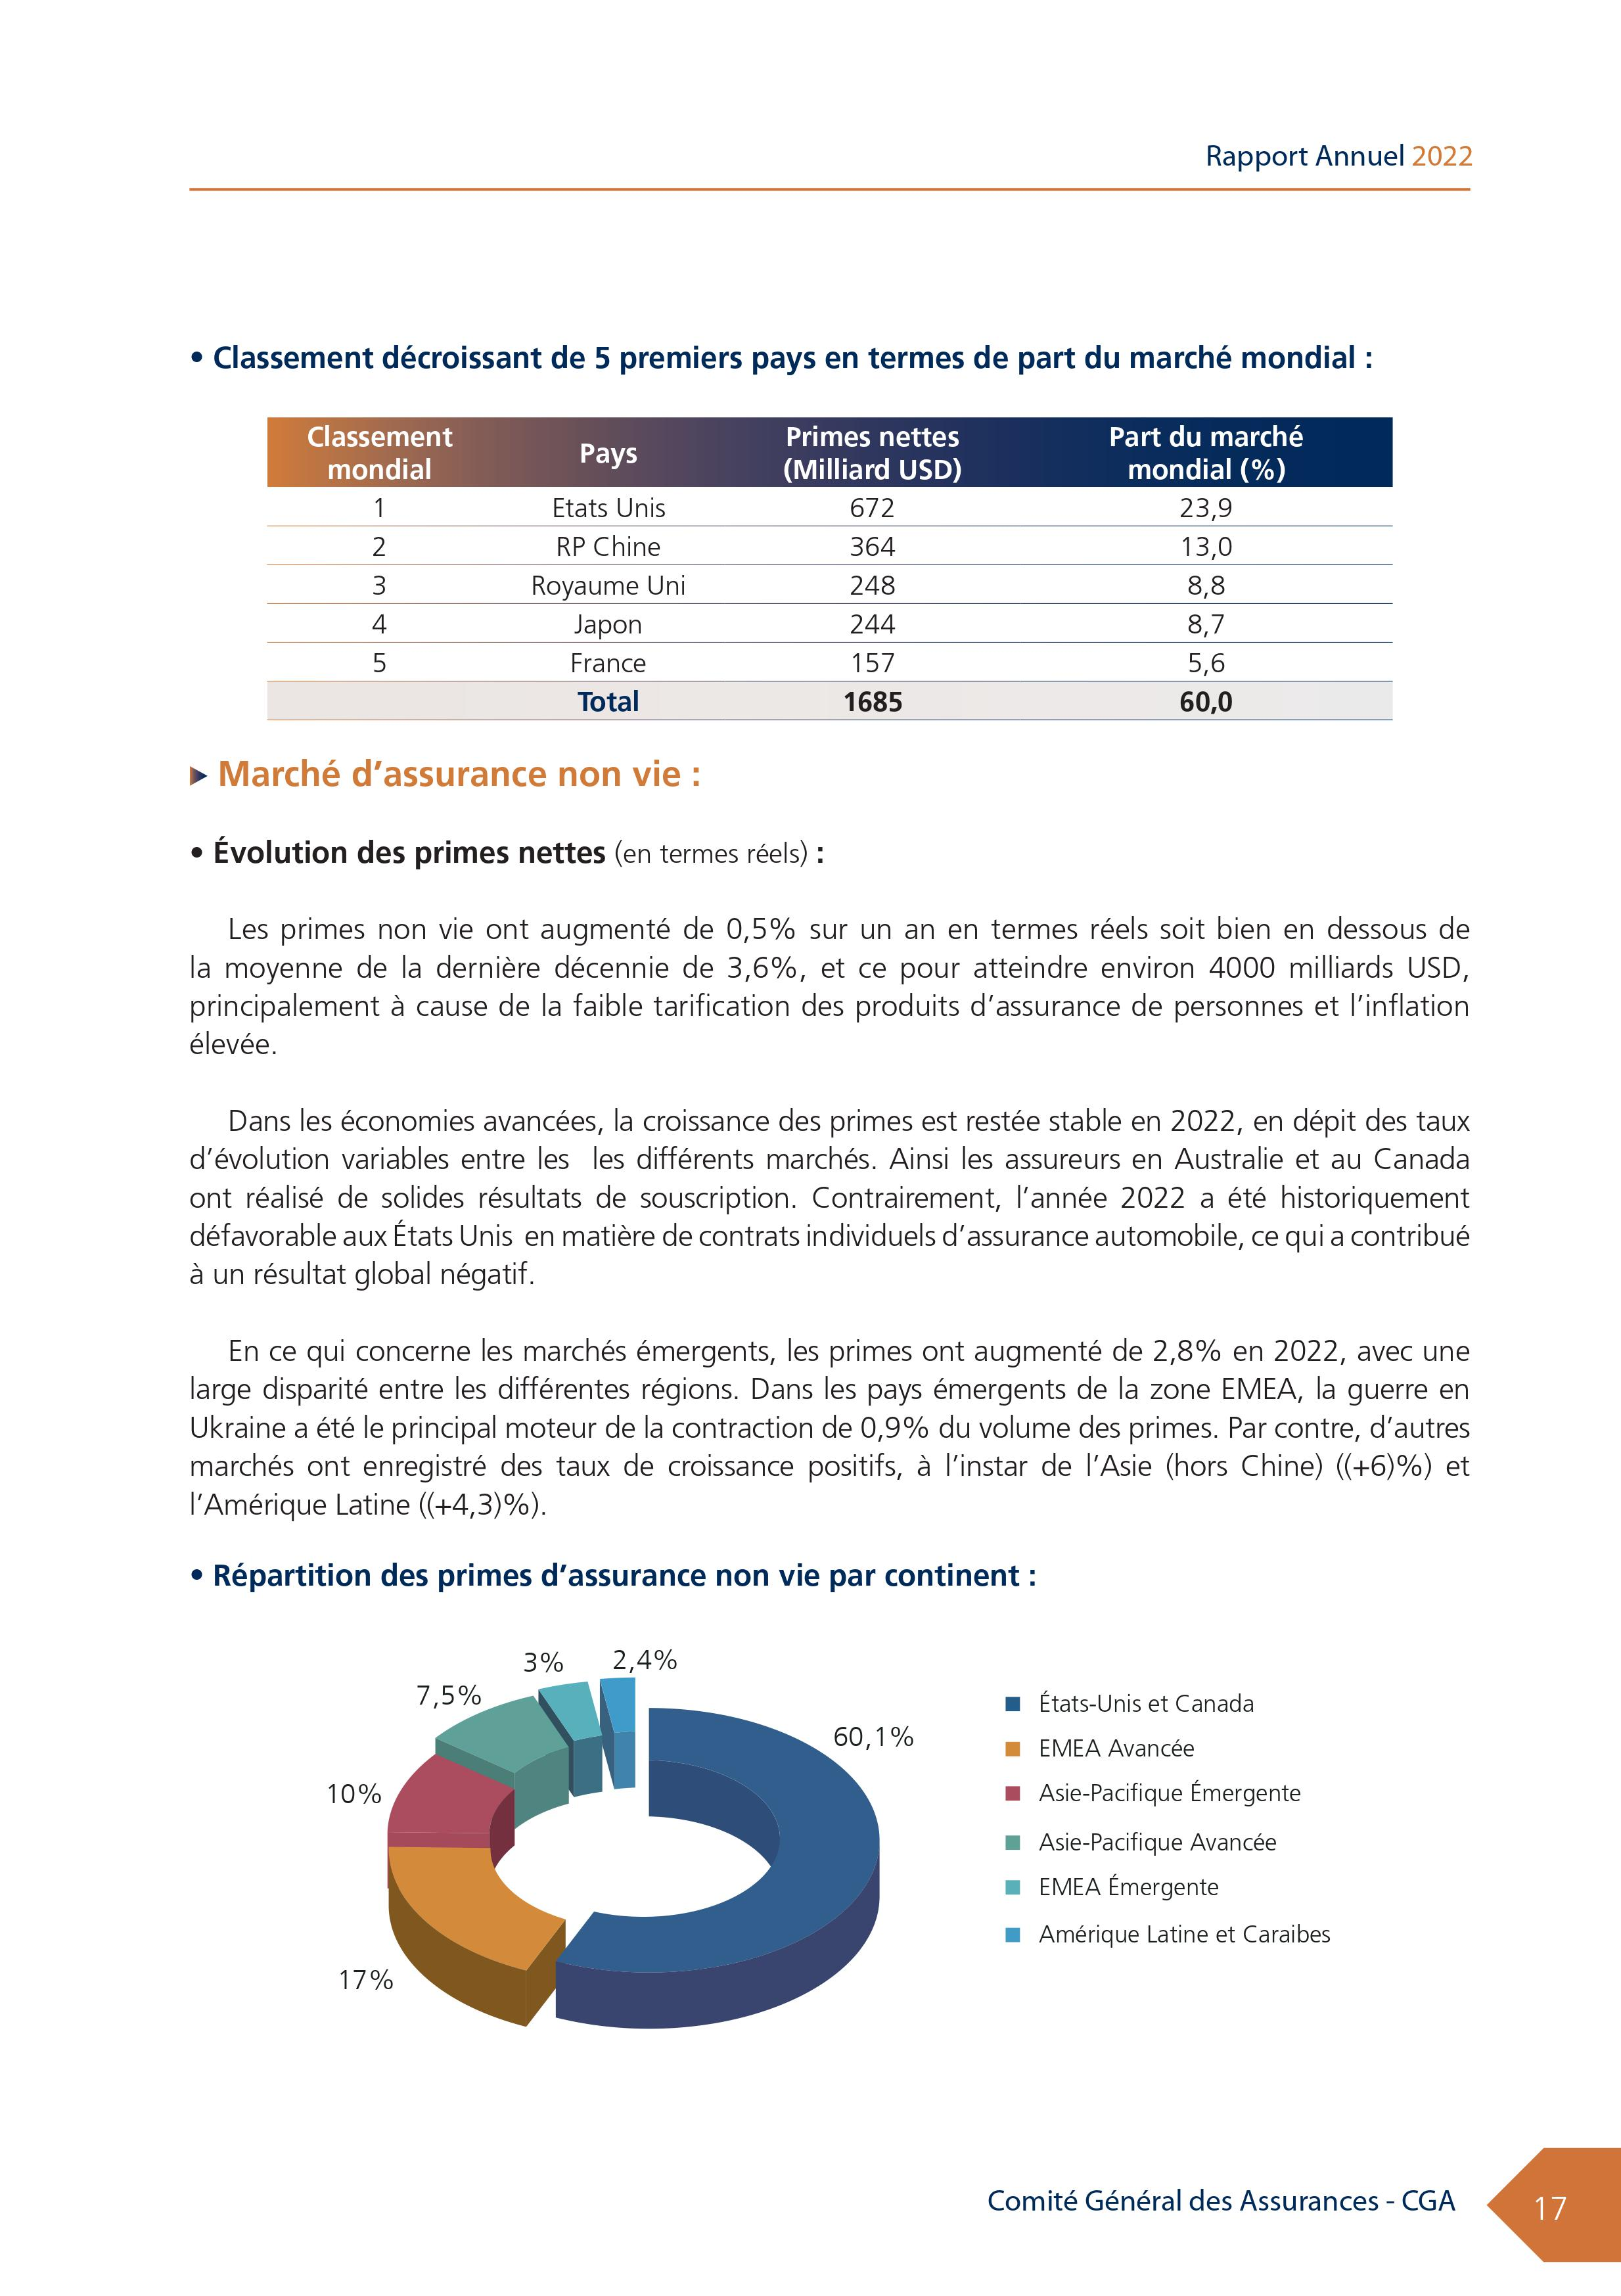

In [38]:
display_vertical_split(
    image_path=image_path, html_content=result_json["natural_text"]
)